# RL with DQN for cart-pole task
- the original DQN code from the pytorch tutorial is in dqn-cart-pole-from-image.ipynb, which is from this [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- this notebook is based on that code, but this notebook uses the low-dimensional state values directly for faster training
- Let's try out various RL algorithms with this toy problem!

In [1]:
import gym
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/yasu/.local/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [2]:
env = gym.make('CartPole-v1').unwrapped
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [3]:
print(f"action space: {env.action_space}\nstate space: {env.observation_space}")

action space: Discrete(2)
state space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


define the network

In [4]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(4, 32)
        self.linear2 = nn.Linear(32, outputs)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [5]:
policy_net = DQN(env.action_space.n)
target_net = DQN(env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)
steps_done = 0

def select_action(state):
    """
    epsilon-greedy action selection
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

In [6]:
episode_durations = []
def plot_durations(ax, fig):
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    ax.cla()
    ax.set_title('Training...')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Duration')
    ax.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)  # pause a bit so that plots are updated

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [18]:
num_episodes = 1300
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.from_numpy(state).float().unsqueeze(0)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations(ax, fig)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode % 100 == 0:
        torch.save(policy_net.state_dict(), f"dqn_model_lite_episode{i_episode}.pth")

KeyboardInterrupt: 

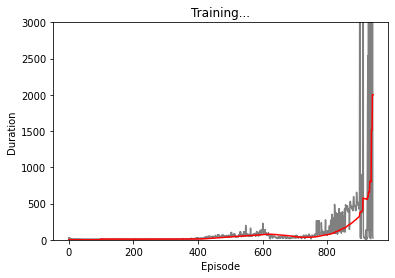

In [27]:
durations_t = torch.tensor(episode_durations, dtype=torch.float)
ax.cla()
ax.set_title('Training...')
ax.set_ylim(0, 3000)
ax.set_xlabel('Episode')
ax.set_ylabel('Duration')
ax.plot(durations_t.numpy(), "gray")
# Take 100 episode averages and plot them too
if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    ax.plot(means.numpy(), "r")
display(fig)

show the control results from the trained network. It learns really well, so must put a fixed cap to the max number of steps otherwise it will go on forever.

In [18]:

# load model
policy_net.load_state_dict(torch.load('dqn_model_lite_episode900.pth'))

state = env.reset()
state = torch.from_numpy(state).float().unsqueeze(0)

fig = plt.figure()
ims = []
for i in count():
    # select action
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)
    state, _, done, _ = env.step(action.item())
    state = torch.from_numpy(state).float().unsqueeze(0)

    # visualization
    if i % 10 == 0:
        ims.append([plt.imshow(env.render(mode='rgb_array'))])
    if done or i > 500:
        break
print(f"frames: {i}")
ani = animation.ArtistAnimation(fig, ims, interval=100)
html = HTML(ani.to_jshtml())
display(html)
plt.close()

frames: 501
